# Lab 3-3 — Weak Supervision: Data Slicing for Email Classification

Models that achieve high **overall** accuracy can still fail badly on important subgroups of the data. In this lab we use Snorkel **slicing functions (SFs)** to identify those subgroups, measure per-slice performance, and apply a targeted fix to improve the weakest slices.

## What Changes vs Lab 1 & 2

- Lab 1 generated labels programmatically (LFs)
- Lab 2 expanded the training set (TFs)
- **This lab** audits a trained model — we use SFs to ask: *where is our model failing, and why?*

SFs are binary masks — they return `True` if a data point belongs to a slice, `False` otherwise. They do not assign labels.

## 1. Setup and Loading Data

In [3]:
import re
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

random.seed(42)
np.random.seed(42)

pd.set_option("display.max_colwidth", 80)

In [4]:
df = pd.read_csv("../lab1/emails.csv")

df_train, df_test = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["label"]
)
df_train = df_train.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

Y_train = df_train["label"].values
Y_test  = df_test["label"].values

print(f"Training set: {len(df_train)} emails")
print(f"Test set:     {len(df_test)} emails")

Training set: 56 emails
Test set:     24 emails


## 2. Train a Baseline Classifier

We first train a standard `LogisticRegression` on the full training set. High overall accuracy can mask poor performance on specific subgroups.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from snorkel.utils import preds_to_probs

vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=1)
X_train = vectorizer.fit_transform(df_train["subject"] + " " + df_train["body"])
X_test  = vectorizer.transform(df_test["subject"] + " " + df_test["body"])

baseline = LogisticRegression(C=1.0, solver="liblinear", random_state=42)
baseline.fit(X_train, Y_train)

preds_test = baseline.predict(X_test)
probs_test = preds_to_probs(preds_test, 2)

print(f"Overall accuracy: {accuracy_score(Y_test, preds_test) * 100:.1f}%")
print(f"Overall F1:       {f1_score(Y_test, preds_test) * 100:.1f}%")
print()
print(classification_report(Y_test, preds_test, target_names=["LEGITIMATE", "PHISHING"]))

Overall accuracy: 79.2%
Overall F1:       81.5%

              precision    recall  f1-score   support

  LEGITIMATE       0.89      0.67      0.76        12
    PHISHING       0.73      0.92      0.81        12

    accuracy                           0.79        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.81      0.79      0.79        24



## 3. Writing Slicing Functions

Slicing functions identify subsets of the data we care about monitoring. Good slices correspond to:
- Structurally distinct email types that might be harder to classify
- Edge cases that are easy to mistake
- High-stakes subgroups (e.g. phishing that avoids obvious keywords)

In [6]:
from snorkel.slicing import slicing_function, SlicingFunction, slice_dataframe, PandasSFApplier

# --- Structural slices ---

@slicing_function()
def sf_short_email(x):
    """Emails with very short bodies — less surface area for keyword-based features."""
    return len(x.body.split()) < 10

@slicing_function()
def sf_long_email(x):
    """Emails with long bodies — more context but also more noise."""
    return len(x.body.split()) > 40

@slicing_function()
def sf_has_url(x):
    """Emails containing a URL in the body — common in phishing but also legitimate."""
    return bool(re.search(r'http[s]?://', x.body))

@slicing_function()
def sf_caps_heavy(x):
    """Emails where the subject contains ALL CAPS words — common phishing signal."""
    words = x.subject.split()
    return sum(1 for w in words if w.isupper() and len(w) > 2) >= 2

In [7]:
# --- Content slices ---

def keyword_slice(keywords):
    """Factory for keyword-based slicing functions."""
    def _fn(x, keywords):
        return any(k in (x.subject + ' ' + x.body).lower() for k in keywords)
    return SlicingFunction(
        name=f"sf_keyword_{keywords[0]}",
        f=_fn,
        resources=dict(keywords=keywords),
    )

# Phishing emails that avoid obvious urgency language — harder to catch
sf_no_urgency = SlicingFunction(
    name="sf_no_urgency_keywords",
    f=lambda x, kws: not any(k in (x.subject + ' ' + x.body).lower() for k in kws),
    resources=dict(kws=["urgent", "immediately", "act now", "warning", "alert", "final notice"]),
)

# Legitimate emails referencing money (invoices, receipts) — easy false positives
sf_legit_money = keyword_slice(["invoice", "receipt", "subscription", "bill", "expense"])

# Re:/Fwd: emails
@slicing_function()
def sf_reply_or_forward(x):
    """Emails with Re: or Fwd: prefix — should almost always be legitimate."""
    return bool(re.match(r'^(re|fwd|fw):', x.subject, re.I))

### Visualize slice membership

In [8]:
sfs = [
    sf_short_email,
    sf_long_email,
    sf_has_url,
    sf_caps_heavy,
    sf_no_urgency,
    sf_legit_money,
    sf_reply_or_forward,
]

# Show size and label breakdown of each slice in the test set
rows = []
for sf in sfs:
    subset = slice_dataframe(df_test, sf)
    n = len(subset)
    if n == 0:
        continue
    phishing_pct = subset["label"].mean() * 100
    rows.append({
        "Slice": sf.name,
        "Test size": n,
        "% Phishing": f"{phishing_pct:.0f}%",
    })

pd.DataFrame(rows)

100%|██████████| 24/24 [00:00<?, ?it/s]


,Slice,Test size,% Phishing
0,sf_short_email,3,67%
1,sf_has_url,4,100%
2,sf_caps_heavy,4,75%
3,sf_no_urgency_keywords,19,37%
4,sf_keyword_invoice,2,100%
5,sf_reply_or_forward,3,0%


In [9]:
# Inspect a specific slice — emails that have URLs
url_slice_df = slice_dataframe(df_test, sf_has_url)
url_slice_df[["subject", "body", "label"]].head(6)

100%|██████████| 24/24 [00:00<?, ?it/s]


,subject,body,label
3,Your crypto wallet has been compromised,Secure your funds now: http://wallet-protect.biz - act within 1 hour.,1
9,Password expiry notice - act immediately,Your password expires in 24 hours. Reset it now at http://pwd-reset.info,1
11,ACCOUNT SUSPENDED - Immediate action required,Log in now to restore access: http://secure-login.info,1
13,Alert: Unusual sign-in activity detected,Someone tried to access your account. Verify at http://login-alert.net,1


## 4. Monitor Per-Slice Performance

We apply all SFs to the test set and use `Scorer.score_slices` to measure F1 on each slice alongside overall performance.

In [10]:
from snorkel.analysis import Scorer

applier = PandasSFApplier(sfs)
S_test = applier.apply(df_test)

# Drop slices that match no rows — score_slices raises ValueError on empty slices
active_sfs = [sf for sf in sfs if S_test[sf.name].astype(bool).sum() > 0]
S_test_active = PandasSFApplier(active_sfs).apply(df_test)

scorer = Scorer(metrics=["f1", "accuracy"])
slice_scores = scorer.score_slices(
    S=S_test_active, golds=Y_test, preds=preds_test, probs=probs_test, as_dataframe=True
)
slice_scores

100%|██████████| 24/24 [00:00<00:00, 8450.58it/s]


,f1,accuracy
overall,0.814815,0.791667
sf_short_email,1.000000,1.000000
sf_has_url,1.000000,1.000000
sf_caps_heavy,0.857143,0.750000
sf_no_urgency_keywords,0.777778,0.789474
sf_keyword_invoice,0.666667,0.500000
sf_reply_or_forward,0.000000,0.666667


**Reading the results:**
- `overall` is the aggregate score across all test points
- Each other row is the score restricted to that slice
- Low F1 on a slice means the model systematically struggles with that subgroup
- Pay attention to slices with both **low F1** and **meaningful size** — small slices with poor scores may just be noise

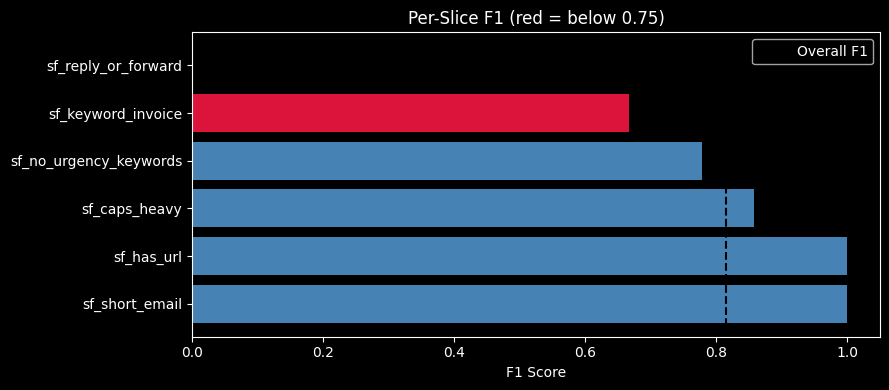

In [11]:
import matplotlib.pyplot as plt

# slice_scores uses slice name as index, not a column
scores_plot = slice_scores[slice_scores.index != "overall"].copy()
scores_plot["slice_name"] = scores_plot.index
colors = ["crimson" if f < 0.75 else "steelblue" for f in scores_plot["f1"]]

plt.figure(figsize=(9, 4))
plt.barh(scores_plot["slice_name"], scores_plot["f1"], color=colors)
plt.axvline(x=slice_scores.loc["overall", "f1"],
            color="black", linestyle="--", label="Overall F1")
plt.xlabel("F1 Score")
plt.title("Per-Slice F1 (red = below 0.75)")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Improve Performance on Weak Slices

For slices with poor performance, a simple and effective fix is to **oversample those slices during training** using `class_weight` or manual resampling. This is more interpretable than a black-box architecture change.

We identify the weakest slice and apply targeted oversampling.

In [12]:
# Identify weakest slice (excluding overall)
worst = slice_scores[slice_scores.index != "overall"].sort_values("f1").iloc[0]
worst_sf_name = worst.name  # index holds the slice name
print(f"Weakest slice: {worst_sf_name}  (F1 = {worst['f1']:.2f})")

Weakest slice: sf_reply_or_forward  (F1 = 0.00)


In [13]:
# Apply SFs to training set to find which training points belong to the weak slice
S_train = PandasSFApplier(active_sfs).apply(df_train)
slice_mask_train = S_train[worst_sf_name].astype(bool)
print(f"Training points in weak slice: {slice_mask_train.sum()} / {len(df_train)}")

100%|██████████| 56/56 [00:00<00:00, 12623.94it/s]

Training points in weak slice: 8 / 56


In [14]:
# Oversample the weak slice in training — duplicate those rows 3x
df_weak_slice = df_train[slice_mask_train]
df_train_boosted = pd.concat([df_train] + [df_weak_slice] * 3, ignore_index=True)
Y_train_boosted = df_train_boosted["label"].values

X_train_boosted = vectorizer.transform(
    df_train_boosted["subject"] + " " + df_train_boosted["body"]
)

print(f"Original training set:  {len(df_train)} emails")
print(f"Boosted training set:   {len(df_train_boosted)} emails")

Original training set:  56 emails
Boosted training set:   80 emails


In [15]:
# Retrain on boosted data
boosted_clf = LogisticRegression(C=1.0, solver="liblinear", random_state=42)
boosted_clf.fit(X_train_boosted, Y_train_boosted)

preds_boosted = boosted_clf.predict(X_test)
probs_boosted = preds_to_probs(preds_boosted, 2)

print(f"Baseline  accuracy: {accuracy_score(Y_test, preds_test) * 100:.1f}%  |  F1: {f1_score(Y_test, preds_test) * 100:.1f}%")
print(f"Boosted   accuracy: {accuracy_score(Y_test, preds_boosted) * 100:.1f}%  |  F1: {f1_score(Y_test, preds_boosted) * 100:.1f}%")

Baseline  accuracy: 79.2%  |  F1: 81.5%
Boosted   accuracy: 79.2%  |  F1: 81.5%


In [16]:
# Compare per-slice scores before and after boosting
S_test_boosted = PandasSFApplier(active_sfs).apply(df_test)
slice_scores_boosted = scorer.score_slices(
    S=S_test_boosted, golds=Y_test, preds=preds_boosted, probs=probs_boosted, as_dataframe=True
)

comparison = slice_scores[["f1"]].merge(
    slice_scores_boosted[["f1"]],
    left_index=True, right_index=True,
    suffixes=("_baseline", "_boosted")
)
comparison = comparison[comparison.index != "overall"].copy()
comparison["delta"] = (comparison["f1_boosted"] - comparison["f1_baseline"]).map(lambda x: f"{x:+.2f}")
comparison

100%|██████████| 24/24 [00:00<00:00, 6819.54it/s]


,f1_baseline,f1_boosted,delta
sf_short_email,1.000000,1.000000,+0.00
sf_has_url,1.000000,1.000000,+0.00
sf_caps_heavy,0.857143,0.857143,+0.00
sf_no_urgency_keywords,0.777778,0.777778,+0.00
sf_keyword_invoice,0.666667,0.666667,+0.00
sf_reply_or_forward,0.000000,0.000000,+0.00


## Summary

**Key takeaways:**
- Overall accuracy is a poor indicator of model reliability — a model can look good globally while failing on important subgroups
- Slicing functions let you define and monitor those subgroups programmatically
- The per-slice F1 breakdown reveals exactly where the model is weak and guides targeted fixes
- Oversampling the weak slice is a simple, interpretable intervention — no architecture changes needed

**What to try:**
- Write a new SF for a different edge case (e.g. emails mentioning dollar amounts that are actually legitimate invoices)
- Try `class_weight='balanced'` in `LogisticRegression` instead of manual oversampling and compare results
- Apply SFs to the training set to understand the data distribution, not just test performance